In [60]:
# https://nikstoyanov.me/post/2018-12-29-regularization-illposed/ - source

In [61]:
import scipy.linalg
import numpy as np

In [62]:
n = 40
t = 1e1

In [63]:
A = np.zeros((1, n))
A[0, 0] = -1
A[0, 1] = 0.5
A[0, -1] = 0.5
L = scipy.linalg.toeplitz(A)

In [64]:
t/n < 1

True

In [65]:
A = scipy.linalg.fractional_matrix_power(np.eye(n) + L, t)

In [66]:
x = np.arange(0, n)
Tt = np.sin(3*np.pi * x / n)

In [67]:
Tfwd = np.dot(A, Tt)
Tfwd

array([ 0.48258534,  0.52670091,  0.54171091,  0.62253495,  0.66895761,
        0.73312732,  0.75678431,  0.75913893,  0.71954341,  0.64474529,
        0.53431844,  0.39482101,  0.23350572,  0.05928686, -0.1182082 ,
       -0.28917105, -0.44415427, -0.57459345, -0.67328051, -0.73476198,
       -0.75564038, -0.73476198, -0.67328051, -0.57459345, -0.44415427,
       -0.28917105, -0.1182082 ,  0.05928686,  0.23350572,  0.39482101,
        0.53431844,  0.64474529,  0.71954341,  0.75913893,  0.75678431,
        0.73312732,  0.66895761,  0.62253495,  0.54171091,  0.52670091])

In [68]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

plt.plot(x, Tt, label='$T_{t}$')
plt.plot(x, Tfwd, label='$T_{t+1}$')

plt.legend()
plt.show()

In [69]:
Tinv = np.dot(np.linalg.inv(A), Tfwd)

In [70]:
np.allclose(np.dot(A, np.linalg.inv(A)), np.eye(n))

False

In [71]:
np.linalg.cond(A)

7.1409730688394664e+16

In [72]:
np.linalg.cond(A) > np.finfo(A.dtype).eps

True

In [73]:
plt.plot(x, Tt, label='$T_{t}$')
plt.plot(x, Tinv, label='$T_{inv}$')

plt.legend()
plt.show()

## Tikhonov Regularization

Tikhonov regularization, with small modification known as Ridge regression in statistics or Weight decay in machine learning can solve the problem by imposing a penalty term λ. Such problems can be formulated as

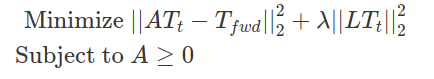

This can be done using a linear least squares solver by lstsq(B,C) where we can implement the Tikhonov regularization in the arguments. For reference, the least squares solver expects problems of the type below.

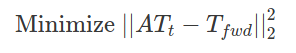

The arguments been to be modified as such:

1.png

and

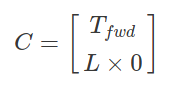

We also need a function to calculate the R2 of the fit.

In [74]:
from scipy.stats import linregress
import numpy as np

def rsqr(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print("slope = ", slope)
    print("intercept = ", intercept)
    print("r_value = ", r_value)
    print("p_value = ", p_value)
    print("std_err = ", std_err)
    print("--------------------------")
    return r_value**2

In [75]:
classifiers = [100, 50, 15, 5, 1, 0.1]
r_squared = []

C = np.concatenate([Tfwd, np.zeros(n)])

fig, ax = plt.subplots(2, 1, figsize=(7.5, 10))
for tikhonov in classifiers:
    B = np.concatenate([A, tikhonov*L])
    T_lstqs =  np.linalg.lstsq(B, C, rcond=None)
    ax[0].scatter(x, T_lstqs[0], label="$\lambda=$" + str(tikhonov))
    
    r_squared.append(rsqr(Tt, T_lstqs[0]))
    ax[1].scatter(tikhonov, r_squared[-1], label="$\lambda=$" + str(tikhonov))

ax[0].plot(x, Tt, label='$T_{t}$', linewidth=2.5, color='black')
ax[0].legend()

ax[1].plot(classifiers, r_squared)
ax[1].legend()
plt.show()

slope =  0.22167328431806457
intercept =  0.16440123043100666
r_value =  0.8163732617609019
p_value =  1.354254760680541e-10
std_err =  0.025439190968587013
--------------------------
slope =  0.44821671122489715
intercept =  0.11654983669218263
r_value =  0.8323322633299286
p_value =  2.7913911492962822e-11
std_err =  0.048420178070646074
--------------------------
slope =  0.7449218300253627
intercept =  0.053878614410886955
r_value =  0.9317211133178943
p_value =  2.6464071451704702e-18
std_err =  0.04710298121438374
--------------------------
slope =  0.9232265330492794
intercept =  0.016216393677420393
r_value =  0.9863646578116938
p_value =  2.1708385412996236e-31
std_err =  0.02498857476909757
--------------------------
slope =  0.9863469486609419
intercept =  0.002883851208052235
r_value =  0.9959698175339056
p_value =  2.0651524199146944e-41
std_err =  0.014408908021030817
--------------------------
slope =  0.996095905485925
intercept =  0.0008246382000011709
r_value =  0.998

## lstsq Solution

For completeness I want to show that we can straight up use lstsq to solve the problem without going in any detail about regularization. However, in doing this we don't learn anything new and we will see in further posts that Tikhonov regularization is indeed needed for solving the bigger optimization problem which is the temperature recovery through the thickness of the specimen to obtain the surface temperature.

In [76]:
Tls = np.linalg.lstsq(A, Tfwd, rcond=None)

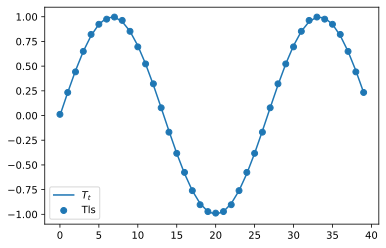

In [77]:
plt.scatter(x, Tls[0], label='Tls')
plt.plot(x, Tt, label='$T_{t}$')
plt.legend()
plt.show()

In [78]:
rsqr(Tt, Tls[0])

slope =  0.9998417881108425
intercept =  3.341813755372569e-05
r_value =  0.9999208908943729
p_value =  7.848209227401196e-74
std_err =  0.0020402974628446007
--------------------------


0.9998417880469963

Conclusion

We have implemented Tikhonov regularization to solve an ill-conditioned inverse problem. Now we can recover temperatures from previous time steps by only using the current results. Stay tuned for the next posts where I will implement the above solution technique to recover temperatures on the exposed surface by readings from thermocouples located in the depth.